In [237]:
import numpy as np
import matplotlib.pyplot as plt
# Synthetic 2-d data with N=100 vectors and not clearly separable clusters
normal = np.loadtxt("./data/normal/normal.txt")
# Synthetic 2-d data with N=6500 vectors and M=8 Gaussian clusters
unbalance = np.loadtxt("./data/unbalance/unbalance.txt")
normal.shape,unbalance.shape

((100, 2), (6500, 2))

In [246]:
class kMeans:
    def __init__(self, k, init='auto',seed=None):
        self.k = k
        self.X = None
        self.centroids = None # coordinates of the points centroids[0] - coordinate of centroid 0
        self.clusters = {i: [] for i in range(k)}# {"centroid idx": ([point coordinates], distance)}
        self.wcd = {i: 0 for i in range(k)}# {"centroid idx": sum of 
        self.init = init
        self.seed = seed
        self.i_centroids = None
    
    def init_centroids_2(self):
        centroids = []
        np.random.seed(self.seed)
        # Choose first centroid randomly
        c_idx = np.random.randint(self.X.shape[0])
        centroids.append(self.X[c_idx,:])
        # Remove from self.X.copy
        options = self.X.copy()
        options = np.delete(options,c_idx,axis=0)

        # while not chosen all k centroids
        while len(centroids) != self.k:
            # distance b/n x and all current centroids
            all_dist_to_prev_c = [min([np.linalg.norm(x-c)**2 for c in centroids]) for x in options]
            # pick the furthest point as next centroid
            c_idx = np.argmax(all_dist_to_prev_c)
            # add it to centroids
            centroids.append(options[c_idx,:])
            # remove it from options
            options = np.delete(options,c_idx,axis=0)
        
        self.centroids = np.stack(centroids)


    def init_centroids(self):
        idx = np.random.choice(self.X.shape[0], self.k, replace=False)
        self.centroids = self.X[idx, :]

        #print("Initial centroids:", self.centroids)

    def nearest_centroid_to(self, x):
        sd = np.fromiter((np.linalg.norm(x-c)**2 for c in self.centroids),dtype=float)
        idx = np.argmin(sd)
        return idx, sd[idx] # return (index of closest centroid, dist)

    def min_intercluster(self):
        # dist between all cluster centers a and b
        self.icd = {i: 0 for i in range(self.k)}
        for j,a in enumerate(self.centroids):
            self.icd[j] = min([np.linalg.norm(a-c) for c in [i for i in self.centroids if not np.array_equal(i,a)]]) # distance to closest cluster
        return min(self.icd.values())

    def fill_clusters(self):
        for x in self.X:
            idx, dist = self.nearest_centroid_to(x)
            ##print("Closest centroid to",x,"is centroid no",idx,"with coordinates",self.centroids[idx], "dist to it:", dist)
            self.clusters[idx].append(x)
            self.wcd[idx] = self.wcd[idx] + dist
            #print(self.wcd)
    
    def update_centroid(self):
        for idx in self.clusters:
            self.centroids[idx] = np.mean(self.clusters[idx],axis=0)
        # clear points in each cluster

    def reset_clusters(self):
        for c in self.clusters:
            self.clusters[c].clear()
        self.wcd = {i: 0 for i in range(self.k)}
    
    def nd_points(self):
        for c in self.clusters:
            self.clusters[c] = np.stack(self.clusters[c])

    def centroids_unchanged(self, prev):
        return np.array_equal(prev,self.centroids)

    def fit(self, X):
        self.X = X
        if (self.init == 'auto'):
            self.init_centroids_2()
        else:
            self.init_centroids()
        self.i_centroids = np.stack(self.centroids)

        old_centroids = None

        while True:
            old_centroids = self.centroids.copy()
            self.fill_clusters()
            self.update_centroid()
            if self.centroids_unchanged(old_centroids):
                break
            else:
                self.reset_clusters()
            #print("Filled clusters. Old centroids were", old_centroids, "New ones are", self.centroids)
        self.nd_points()
        
        self.inertia = sum(self.wcd.values())
        self.dunn_index = self.min_intercluster() / max(self.wcd.values())

            


In [239]:
def plot_clusters(model):
    for c in model.clusters:
        x = model.clusters[c][:,0]
        y = model.clusters[c][:,1]
        plt.plot(x,y,'o')
        center = model.centroids[c]
        plt.plot(center[0],center[1],'X',markersize=10,color='red')
    plt.title("{} clusters".format(model.k))

In [240]:
def random_restart(k, X, restarts=10, init='auto', scoring='dunn'):
    best_score = -np.inf if scoring=='dunn' else +np.inf
    best_model = None
    for i in range(restarts):
        model = kMeans(k,init=init)
        model.fit(X)
        if scoring=='dunn' and model.dunn_index > best_score:
            best_score = model.dunn_index
            best_model = model
        elif scoring=='inertia' and model.inertia < best_score:
            best_score = model.inertia
            best_model = model
    return best_model

In [266]:
def optimal_k(X, a=2,b=12,j=2,r=1,scoring='dunn'):
    score = []
    ks = range(a,b+1,j)
    for k in ks:
        model = random_restart(k,X,r,scoring)
        if scoring == 'dunn':
            score.append(model.dunn_index)
        else:
            score.append(model.inertia)
    
    plt.plot(ks,score)
    plt.xlabel("k")
    plt.ylabel(scoring)
    plt.title("optimal k")
    return np.argmin(score)

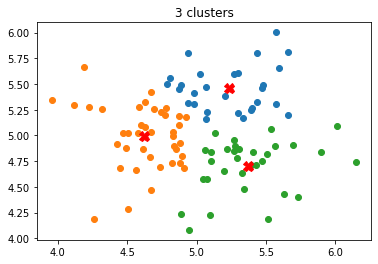

In [242]:
kmeans_n = random_restart(k=3,init='random',X=normal,restarts=15)
plot_clusters(kmeans_n)

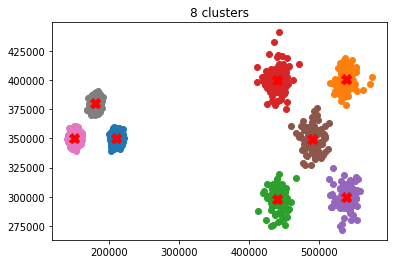

In [254]:
# doesnt always pick the right one
kmeans_1 = kMeans(8)
kmeans_1.fit(unbalance)
plot_clusters(kmeans_1)

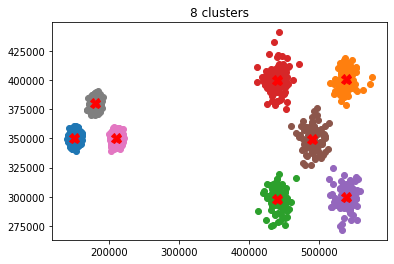

In [255]:
kmeans_best = random_restart(8,unbalance)
plot_clusters(kmeans_best)